In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.sparse import csr_matrix,load_npz, coo_matrix, linalg, identity, hstack, lil_array
from tqdm import tqdm
from math import log,exp,sqrt
import logging
import copy
from sklearn.metrics import roc_curve, auc
from scipy.sparse import csr_matrix, linalg, identity, lil_matrix, hstack
import networkx as nx

contig_file = "../data/corrected_contig_info_combine.csv"
raw_contact_file = "../data/raw_contact_matrix.npz"
path = "../data"

## Auxiliary Function


In [2]:
def normcc(df):

    df['log_site'] = np.log(df['site'])
    df['log_length'] = np.log(df['length'])
    df['log_covcc'] = np.log(df['covcc'])
    
    exog = df[['log_site', 'log_length', 'log_covcc']]
    endog = df["signal"]
    exog = sm.add_constant(exog)
    glm_nb = sm.GLM(endog, exog, family=sm.families.NegativeBinomial(alpha=1))
    res = glm_nb.fit(method="lbfgs")

    return res.params

In [3]:
def sum_rows_excluding_diagonal(sparse_mat):
    sparse_mat = csr_matrix(sparse_mat)
    # Get the shape of the matrix
    n_rows, n_cols = sparse_mat.shape

    # Initialize an array to store the row sums
    row_sums_excluding_diagonal = np.zeros(n_rows)

    # Iterate over each row
    for i in range(n_rows):
        # Get the start and end indices of the data in the current row
        start_index = sparse_mat.indptr[i]
        end_index = sparse_mat.indptr[i + 1]

        # Get the column indices and data for the current row
        row_indices = sparse_mat.indices[start_index:end_index]
        row_data = sparse_mat.data[start_index:end_index]

        # Sum the elements excluding the diagonal element
        row_sum = sum(row_data[j] for j in range(len(row_data)) if row_indices[j] != i)

        # Store the sum in the result array
        row_sums_excluding_diagonal[i] = row_sum

    return row_sums_excluding_diagonal


In [4]:
def normalizemap(norm_params, metadata, contact_matrix):
    contact_matrix = contact_matrix.tocoo()
    norm_data = []
    mu_vector = []
    for site, length, covcc in zip(metadata["site"], metadata['length'], metadata['covcc']):
        mu_vector.append(np.exp(log(site) * norm_params['log_site'] +
                    log(length) * norm_params['log_length'] +
                    log(covcc) * norm_params['log_covcc'] +
                    norm_params['const']))
        
    scale = np.max(mu_vector)
    for idx, value in enumerate(contact_matrix.data):
        i, j = contact_matrix.row[idx], contact_matrix.col[idx]
        norm_value = scale * value / np.sqrt(mu_vector[i] * mu_vector[j])
        norm_data.append(norm_value)
    
    return coo_matrix((norm_data, (contact_matrix.row, contact_matrix.col)), shape=contact_matrix.shape)

In [5]:
def calculate_true_positive(contact_matrix, metadata, self_loop):
    species_map = dict(zip(metadata['name'], metadata['True_identity']))
    true_positives = set()
    for i, j in zip(contact_matrix.row, contact_matrix.col):
        if i == j and self_loop == False:
            continue  # Skip self-loops
        contig1 = metadata.loc[i, 'name']
        contig2 = metadata.loc[j, 'name']
        if species_map.get(contig1) == species_map.get(contig2):
            true_positives.add((i, j))
    return true_positives



In [6]:
# Function to calculate AUDRC
def calculate_audrc(scores):
    scores.sort(key=lambda x: x[2], reverse=True)
    true_positive_count = sum(1 for _, _, _, is_tp in scores if is_tp)
    spurious_contact_count = len(scores) - true_positive_count
    tpr = []
    discard_proportion = []
    thresholds = np.percentile([x[2] for x in scores], np.arange(0, 100, 5))
    for threshold in thresholds:
        tp_cumsum = sum(1 for _, _, score, is_tp in scores if score >= threshold and is_tp)
        spurious_cumsum = sum(1 for _, _, score, is_tp in scores if score < threshold and not is_tp)
        tpr.append(tp_cumsum / true_positive_count)
        discard_proportion.append(spurious_cumsum / spurious_contact_count)
    audrc = auc(discard_proportion, tpr)
    return audrc, tpr, discard_proportion

In [ ]:
auc_rw_raw, tpr_rw_raw, discard_rw_raw = calculate_audrc(rw_score_raw)

KeyboardInterrupt: 

In [ ]:
true_positive_count = sum(1 for _, _, _, is_tp in scores if is_tp)
spurious_contact_count = len(scores) - true_positive_count
tpr = []
discard_proportion = []
thresholds = np.percentile([x[2] for x in scores], np.arange(0, 100, 5))


In [23]:
sum([x[3] for x in scores])

801217

In [7]:
## utils for global similarity
def nodes_to_indexes(G: nx.Graph):
    """Node Label - Index encoder

    Associate, for each node label, and index starting from 0.

    Parameters
    ----------
    G: nx.Graph :
        the graph from which you want the node-to-index mapping

    Returns
    -------
    Dict[Any, int]: the encoding Node Label - Index dictionary

    Notes
    -----
    The method `Graph.nodes` return the nodes in the exactly same order, and
    the first node (at index 0) represent the index 0 in the Adjacency Matrix
    obtained with the method `Graph.to_adjacency_matrix` or
    `Graph.to_numpy_array`.
    """
    return {node_name: index for index, node_name in enumerate(G.nodes)}

def to_adjacency_matrix(G: nx.Graph,
                        sparse: bool = True):
    """Convert a ginven Graph in to its Adjacency Matrix

    Parameters
    ----------
    G: nx.Graph :
        input Graph (a networkx Graph)
    sparse: bool:
        if True, return the Adjacency Matrix in sparse format,
        otherwise in full format.
         (Default value = True)

    Returns
    -------
    csc_matrix | np.ndarray: the Adjacency Matrix
    """
    # TODO: ricontrollare se i pesi servono
    return nx.adjacency_matrix(
        G, weight=None) if sparse else nx.to_numpy_array(G, weight=None)

def only_unconnected(graph: nx.Graph, sim_matrix: lil_matrix):
    """Filter the given matrix and return only previously unconnected
    nodes "similarity" values

    Parameters
    ----------
    graph: nx.Graph :
        input graph
    sim_matrix: csr_matrix :
        similarity matrix

    Returns
    -------
    sim_matrix: csr_matrix : the similarity matrix without the previously
    connected nodes similarity
    """
    node_idexies_map = nodes_to_indexes(graph)

    for x, y in graph.edges():
        sim_matrix[node_idexies_map[x], node_idexies_map[y]] = 0

    sim_matrix = sim_matrix.tocsr()
    sim_matrix.eliminate_zeros()

    return sim_matrix.tocsr()

In [8]:
def link_prediction_rwr(G: nx.Graph,
                        c: int = 0.05,
                        max_iters: int = 10) -> csr_matrix:
    """Compute the Random Walk with Restart Algorithm.

    The similarity between two nodes is defined as:

    .. math::
        S(x, y) = q_{xy} + q_{yx}

    where \\(q_x\\) is defined as \\( (1-\\alpha) (I - \\alpha P^T)^{-1} e_x\\)
    and \\(e_x\\) is the seed vector of length \\(|V|\\).

    Parameters
    ----------
    G: nx.Graph :
        input Graph (a networkx Graph)
    c: int :
        TODO
         (Default value = 0.05)
    max_iters: int :
        max number of iteration for the algorithm convergence
         (Default value = 10)

    Returns
    -------
    similarity_matrix: csr_matrix : the Similarity Matrix (in sparse format)

    Notes
    -----
    Let \\(\\alpha\\) be a probability that a random walker
    iteratively moves to an arbitrary neighbor and returns to the same
    starting vertex with probability \\( (1 - \\alpha )\\).
    Consider \\(q_{xy}\\) to be the probability that a random walker
    who starts walking from vertex x and located at the vertex y in steady-state.

    The seed vector \\(e_x\\) consists of zeros for all components except the
    elements \\(x\\) itself.

    The transition matrix \\(P\\) can be expressed as

    .. math::
        P_{xy} = \\begin{cases}
                \\frac{1}{k_x} & \\text{if } x \\text{ and } y \\text{ are connected,} \\\\
                0 & \\text{otherwise.}
            \\end{cases}
    """

    def random_walk_with_restart(e: lil_array,
                                 W_normalized: csr_matrix,
                                 c: int = 0.05,
                                 max_iters: int = 100) -> lil_array:
        """Generates the probability vector

        Parameters
        ----------
        e: lil_array :
            input probability vector
        W_normalized: csr_matrix :
            TODO
        c: int :
            TODO
             (Default value = 0.05)
        max_iters: int :
            max number of iteration for the algorithm convergence
             (Default value = 100)

        Returns
        -------
        e: lil_array : the updated probability vector
        """
        # Initialize the current probability vector to the initial one and the error to 1
        old_e = e
        err = 1.

        # Perform the random walk with restart until the maximum number
        # of iterations is reached or the error becomes less than 1e-6
        for _ in range(max_iters):
            e = (c * (W_normalized @ old_e)) + ((1 - c) * e)
            err = linalg.norm(e - old_e, 1)
            if err <= 1e-6:
                break
            old_e = e

        # Return the current probability vector
        return e

    # Convert the graph G into an adjacency matrix A
    A = to_adjacency_matrix(G)

    # Extract the number of nodes of matrix A
    m = A.shape[0]

    # Initialize the diagonal matrix D as a sparse lil_matrix
    D = lil_matrix(A.shape)

    # Create a map that associates each node with a row index in matrix A
    nodes_to_indexes_map = nodes_to_indexes(G)

    # Build the diagonal matrix D so that the elements on the diagonal
    # are equal to the degree of the corresponding node
    for node in G.nodes():
        D[nodes_to_indexes_map[node],
          nodes_to_indexes_map[node]] = G.degree[node]

    # Convert the diagonal matrix D into csc_matrix format
    D = D.tocsc()

    try:
        # Build the normalized transition matrix W_normalized
        W_normalized = linalg.inv(D) @ A.tocsc()
    except RuntimeError as e:
        print('Possible presence of singleton nodes in the graph G')
        print(e)
        exit(1)

    # Initialize an matrix to hold the similarities between node pairs
    # We put an initial column made of Zeros so we can use the hstack
    # method later on and keep the code more clean
    similarity_matrix = csr_matrix((m, 1))

    # For each node i, create a probability vector and perform the
    # random walk with restart starting from that node
    for i in range(m):
        e = lil_array((m, 1))
        e[i, 0] = 1
        # Concatenate the similarity vectors into a similarity matrix
        # The use of hstack allows the lil_array returned from the
        # random walk function to be transposed and added to the
        # similarity matrix as a new column in just one line of code
        similarity_matrix = hstack([
            similarity_matrix,
            random_walk_with_restart(e=e,
                                     W_normalized=W_normalized,
                                     c=c,
                                     max_iters=max_iters)
        ])

    # Return the similarity matrix and remove the fisrt column
    # In order to keep the results consistent without the added column of zeros at the beginning
    return only_unconnected(G, csr_matrix(similarity_matrix)[:, 1:])

## Data Loading and Preparation

In [9]:
contact_matrix = load_npz(raw_contact_file).tocoo()
meta_data = pd.read_csv(contig_file)

In [10]:
names = ['name', 'site', 'length', 'coverage', 'covcc', "True_identity"]
meta_data.columns = names

In [11]:
# Calculate the row sums excluding the diagonal
signal = sum_rows_excluding_diagonal(contact_matrix)
meta_data["signal"] = signal

In [12]:
# calculate the coffecient
coffecient = normcc(meta_data)

In [13]:
norm_contact_matrix = normalizemap(coffecient, meta_data, contact_matrix)

## Global similarity calculation

In [14]:
## calculate the valid contacts in the map
true_contact = calculate_true_positive(contact_matrix, meta_data, True)

In [15]:
adj_matrix_raw = contact_matrix.toarray()
adj_matrix_norm = norm_contact_matrix.toarray()

In [16]:
# Create a graph from the adjacency matrix
G_raw = nx.Graph()
# Add edges with weights to the graph
for i in range(len(adj_matrix_raw)):
    for j in range(len(adj_matrix_raw[i])):
        weight = adj_matrix_raw[i][j]
        if weight != 0:
            G_raw.add_edge(i, j, weight=weight)


In [17]:
# Create a graph from the adjacency matrix
G_norm = nx.Graph()
# Add edges with weights to the graph
for i in range(len(adj_matrix_norm)):
    for j in range(len(adj_matrix_norm[i])):
        weight = adj_matrix_norm[i][j]
        if weight != 0:
            G_norm.add_edge(i, j, weight=weight)
            

In [18]:
matrix_raw = link_prediction_rwr(G_raw).tocoo()

In [19]:
matrix_norm = link_prediction_rwr(G_norm).tocoo()

### Calculate the Audrc

In [20]:
rw_score_raw  = [(i, j, score, (i, j) in true_contact) for (i, j, score) in zip(matrix_raw.row, matrix_raw.col, matrix_raw.data)]
rw_score_norm = [(i, j, score, (i, j) in true_contact) for (i, j, score) in zip(matrix_norm.row, matrix_norm.col, matrix_norm.data)]


In [24]:
auc_rw_raw, tpr_rw_raw, discard_rw_raw = calculate_audrc(rw_score_raw)


In [25]:
auc_rw_norm, tpr_rw_norm, discard_rw_norm = calculate_audrc(rw_score_norm)


In [26]:
# Function to plot the discard-retain curve
def plot_discard_retain_curve(discard_proportion, tpr, audrc, method_label, color):
    plt.plot(discard_proportion, tpr, label=f'{method_label}: {audrc:.3f}', color=color)

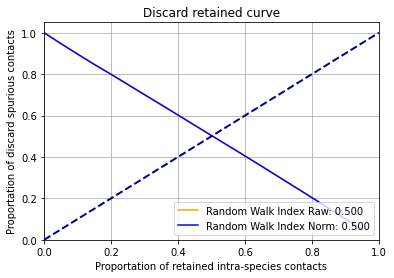

In [27]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2  # line width


plot_discard_retain_curve(discard_rw_raw, tpr_rw_raw, auc_rw_raw, 'Random Walk Index Raw', 'orange')
plot_discard_retain_curve(discard_rw_norm, tpr_rw_norm, auc_rw_norm, 'Random Walk Index Norm', 'blue')



plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proportation of retained intra-species contacts')
plt.ylabel('Proportation of discard spurious contacts')
plt.title('Discard retained curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()